In [1]:
import time
import pickle
import numpy as np
import pprint
import matplotlib.pyplot as plt
from tqdm import tqdm 
import json
from dateutil.parser import parse

In [2]:
from rdbtools import RdbParser, RdbCallback
from rdbtools.encodehelpers import bytes_to_unicode

class PublishCallback(RdbCallback):

    def __init__(self, is_unicode=False, start_ts=float('-inf'), stop_ts=float('+inf')):
        super(PublishCallback, self).__init__(string_escape=None)
        self.ranges = {}
        self.start = start_ts
        self.stop = stop_ts
        self.is_unicode = is_unicode

    def encode_key(self, key):
        return bytes_to_unicode(key, self._escape, skip_printable=True)

    def encode_value(self, val):
        if self.is_unicode:
            return bytes_to_unicode(val, self._escape)
        return val

    def start_sorted_set(self, key, length, expiry, info):
        self.ranges[self.encode_key(key)] = []

    def zadd(self, key, score, member):
        if self.start <= score <= self.stop:
            self.ranges[self.encode_key(key)].append((self.encode_value(member), round(score)))

    def end_sorted_set(self, key):
        encoded_key = self.encode_key(key)
        self.ranges[encoded_key] = list(reversed(self.ranges[encoded_key]))


def parse_dump_file(dump_file, start_ts=float("-inf"), stop_ts=float("+inf")):
    """Parse a redis dump file (rdb) and return the data within.

    Only supports SortedSet.

    Args:
        dump_file (str): Rdb path
        start_ts (float): timestamp of the first value to publish
        stop_ts (float): timestamp of the last value to publish

    Returns:
        ranges (dict): {
                'keyA': [(FrameDataDump1A, Score1A), ..., (FrameDataDumpNA, ScoreNA)],
                'keyB': [(FrameDataDump1B, Score1B), ..., (FrameDataDumpNB, ScoreNB)],
                ...
            }
    """
    t0 = time.time()

    callback = PublishCallback(start_ts=start_ts, stop_ts=stop_ts)
    rdb_parser = RdbParser(callback)
    rdb_parser.parse(dump_file)
    print("Parsed {} in {:.2f} s.".format(dump_file, time.time() - t0))
    print("Contains keys:", callback.ranges.keys())
    for k in callback.ranges.keys():
        print(
            "[{}] start_ts: {} | stop_ts: {}".format(
                k, callback.ranges[k][0][1], callback.ranges[k][-1][1]
            )
        )
    return callback.ranges

In [3]:
from ipywidgets import interact
import ipywidgets as widgets

In [208]:
tracks = parse_dump_file('../kickoff-detection-data/cbcca433-ff77-4927-a5a3-36ff293c12fd.2.kickoff.rdb')
config = json.load(open('../kickoff-detection-data/cbcca433-ff77-4927-a5a3-36ff293c12fd.json', 'r'))

Parsed ../kickoff-detection-data/cbcca433-ff77-4927-a5a3-36ff293c12fd.2.kickoff.rdb in 1.41 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523296748330 | stop_ts: 1523297346370
[left] start_ts: 1523296760048 | stop_ts: 1523297356248


In [209]:
fd, ts = tracks['left'][0]


fd = pickle.loads(fd)
pprint.pprint(fd.__dict__.keys())

dict_keys(['valid_frame', 'ball_detections', 'phase_state', 'player_detections', 'features', 'mapping', 'stream_ts', 'bboxes', 'top_view_ball_positions', 'top_view_player_positions', 'ts', 'last', 'embeddings', 'packed_rects'])


In [210]:
kickoff_1 = config['phase_events'][2]['ts']
kickoff_time = int(parse(kickoff_1).timestamp()*1000)

In [211]:
config['phase_events']

[{'kickoff_team_id': 15,
  'phase': 1,
  'ts': '2018-04-09T17:00:44.667Z',
  'type': 'start_phase'},
 {'phase': 1, 'ts': '2018-04-09T17:47:46.113Z', 'type': 'end_phase'},
 {'kickoff_team_id': 5,
  'phase': 2,
  'ts': '2018-04-09T18:04:16.558Z',
  'type': 'start_phase'},
 {'phase': 2, 'ts': '2018-04-09T18:53:12.188Z', 'type': 'end_phase'}]

In [212]:
pitch_size=config['pitch_size']

In [213]:
detections = {'ball':{'left':{}, 'right':{}}, 'players':{'left':{}, 'right':{}}}

timestamps = set()

def ball_ok(ball_pos, ball_det):
    if ball_pos[0] < 0 or ball_pos[1] < 0:
        return False
    if ball_det.confidence < 0.7:
        return False
    return True

for (fd_left, ts_left), (fd_right, ts_right) in tqdm(zip(tracks['left'], tracks['right'])):
    fd_left = pickle.loads(fd_left)
    fd_right = pickle.loads(fd_right)
    if np.abs(ts_left - ts_right) < 100:
        ts_left = ts_right
    timestamps.update({ts_left, ts_right})

    detections['players']['left'][ts_left] = fd_left.top_view_player_positions
    detections['players']['right'][ts_right] = fd_right.top_view_player_positions
    detections['ball']['left'][ts_left] = np.array([bp for bp, bd in zip(fd_left.top_view_ball_positions, fd_left.ball_detections) if ball_ok(bp, bd)])
    detections['ball']['right'][ts_right] = np.array([bp for bp, bd in zip(fd_right.top_view_ball_positions, fd_right.ball_detections) if ball_ok(bp, bd)])
    

14906it [00:06, 2457.35it/s]


1523297056558 1523297056568


<IPython.core.display.Javascript object>


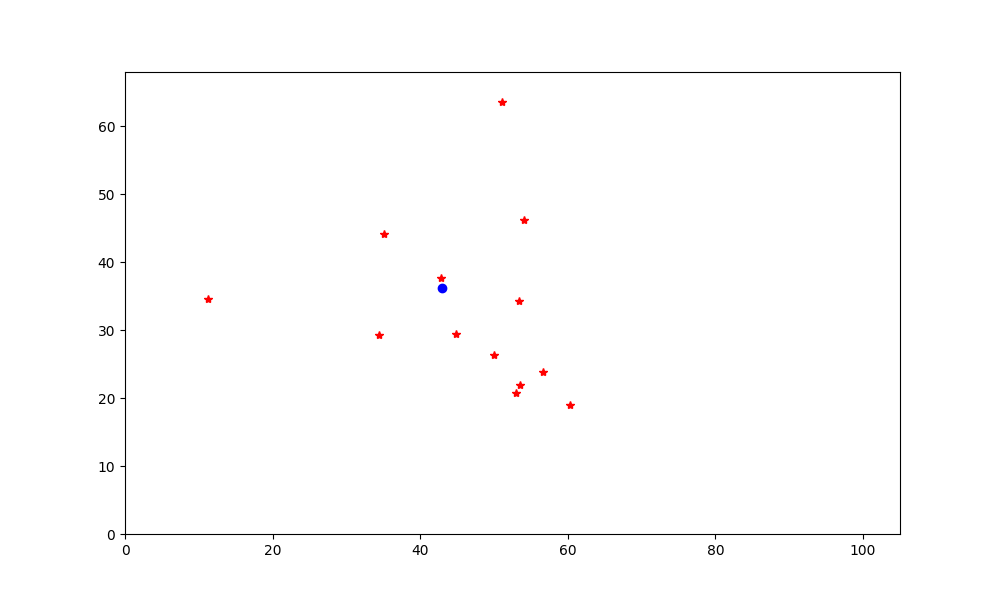

interactive(children=(SelectionSlider(description='ts', index=15119, options=(1523296748330, 1523296748370, 15…

In [214]:
timestamps_list = sorted(list(timestamps))
kickoff_time_ind = np.argmin(np.abs(np.subtract(timestamps_list, kickoff_time)))
kickoff_time_matched = timestamps_list[kickoff_time_ind]
print(kickoff_time, kickoff_time_matched)

%matplotlib notebook

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
left, = plt.plot([], '*r')
right, = plt.plot([], '*r')

left_b, = plt.plot([], 'ob')
right_b, = plt.plot([], 'ob')

plt.xlim([0, 105])
plt.ylim([0, 68])

def update(ts=kickoff_time_matched):
    if ts in detections['players']['left']:
        left.set_ydata(detections['players']['left'][ts][:, 1])
        left.set_xdata(detections['players']['left'][ts][:, 0])
    else:
        left.set_ydata([])
        left.set_xdata([])
        
    if ts in detections['players']['right']:
        right.set_ydata(detections['players']['right'][ts][:, 1])
        right.set_xdata(detections['players']['right'][ts][:, 0])
    else:
        right.set_ydata([])
        right.set_xdata([])

    if ts in detections['ball']['left'] and len(detections['ball']['left'][ts]):
        left_b.set_ydata(detections['ball']['left'][ts][:, 1])
        left_b.set_xdata(detections['ball']['left'][ts][:, 0])
    else:
        left_b.set_ydata([])
        left_b.set_xdata([])        
    if ts in detections['ball']['right'] and len(detections['ball']['right'][ts]):
        right_b.set_ydata(detections['ball']['right'][ts][:, 1])
        right_b.set_xdata(detections['ball']['right'][ts][:, 0])
    else:
        right_b.set_ydata([])
        right_b.set_xdata([])
    
    
wid = widgets.SelectionSlider(
    options=timestamps_list,
    value=kickoff_time_matched,
    continuous_update=True,
    orientation='horizontal',
    readout=True
)
    
interact(update, ts = wid);

In [11]:
# {'id': 'd1a98e08-0f21-46fe-8457-01ff183ddbeb', 'calibration': {'views': ['left', 'right'], 'reference_landmarks': {'object': 'calibrations/tele2_landmarks.json', 'bucket': 'signality.ironfist.models'}}, 'replay_urls': ['//liveplay.signality.com/data/d1a98e08-0f21-46fe-8457-01ff183ddbeb_phase1.data', '//liveplay.signality.com/data/d1a98e08-0f21-46fe-8457-01ff183ddbeb_phase2.data'], 'camera_mode': 'static', 'away_team': {'colors': {'team': '#000000', 'goalkeeper': '#ffff00'}, 'logo_url': 'http://images.signality.com/team-logos/orebro.png', 'name': 'Örebro SK'}, 'phase_events': [{'type': 'start_phase', 'ts': datetime.datetime(2018, 5, 17, 17, 0, 2, 362000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e4e0>), 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': datetime.datetime(2018, 5, 17, 17, 47, 7, 92000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e518>), 'phase': 1}, {'type': 'start_phase', 'ts': datetime.datetime(2018, 5, 17, 18, 4, 2, 891000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e630>), 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': datetime.datetime(2018, 5, 17, 18, 52, 6, 565000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e6a0>), 'phase': 2}], 'start_time': datetime.datetime(2018, 5, 17, 19, 0, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e780>), 'state': 'Destroyed', 'external_data': {'smc': {'match_id': 3704, 'home_team_id': 11, 'league_id': 12, 'away_team_id': 12}}, 'streams': {'left': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/ca074983-09a2-451f-8730-90efa6701dc8/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 197000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e9e8>)}, 'autofollow_render_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/d890161e-59fa-4f39-9758-b9d5b10357af/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 197000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e9b0>)}, 'virtual_panorama_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/b5e093f3-f8e7-4643-a87a-d9a76256a735/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 197000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61ec88>)}, 'goal_south_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/c841f705-de34-4428-b56e-7c9803ab4eca/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 143000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61eac8>)}, 'right': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/d8112841-7cf8-48ae-89ce-f327c282916c/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 124000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61ea20>)}, 'goal_north_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/9a7b8e83-dbc0-436b-a116-7f8d085057c2/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 141000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61ea58>)}}, 'pitch_size': [105, 68], 'home_team': {'colors': {'team': '#5a9dde', 'goalkeeper': '#ffffff'}, 'logo_url': 'http://images.signality.com/team-logos/djurgarden.png', 'name': 'Djurgårdens IF'}, 'referees': {'colors': '#000000'}, 'competition': 'Allsvenskan', 'redis': {'host': 'redis', 'port': 6379}, 'rethinkdb': {'host': 'db.signality.com', 'user': 'game_viewer', 'db': 'livetrack', 'ssl': {'ca_certs': '/home/ubuntu/workspace/ironfist/ironfist/utils/../applications/livetrack/config/db.signality.cert.pem'}, 'password': 'MmPHrqmXaVeu', 'port': 28015}, 'nchan': {'url': 'http://nchan:8080'}, 'arena': 'Tele2 Arena', 'stats': [{'home_team': {'failed_passes': 163, 'possessing_team': 0, 'passes': 181, 'distance': 62777.64480394193, 'possession': 25067, 'packing': 260}, 'source': 'signality', 'phase': 1, 'away_team': {'failed_passes': 163, 'possessing_team': 1, 'passes': 191, 'distance': 60097.76136929008, 'possession': 23934, 'packing': 252}, 'utc_time': 1526579225125, 'match_time': 2822763}, {'home_team': {'failed_passes': 157, 'possessing_team': 0, 'passes': 147, 'distance': 62576.815733754884, 'possession': 20009, 'packing': 196}, 'source': 'signality', 'phase': 2, 'away_team': {'failed_passes': 158, 'possessing_team': 1, 'passes': 206, 'distance': 57684.92804763888, 'possession': 28384, 'packing': 240}, 'utc_time': 1526583124565, 'match_time': 2881674}], 'video_shape': [2160, 3840, 3], 'rdb': [{'key': '20180517.djurgårdens-if-örebro-sk.2.rdb', 'bucket': 'signality.soccer.backup', 'phase': 2}]}

In [11]:
def select_time(time_list,detections):
    l=list()
    truth_list=list()
    for i in range(len(time_list)):
        truth_list.append(True)
        if time_list[i] in detections['players']['left'] and time_list[i] in detections['players']['right']:
            l.append([time_list[i],time_list[i]])
            truth_list[i]=False
        if i>0:
            if time_list[i-1] in detections['players']['left'] and time_list[i] in detections['players']['right'] and truth_list[i] and truth_list[i-1] and time_list[i]-time_list[i-1]<=20:
                l.append([time_list[i-1],time_list[i]])
                truth_list[i]=False
            if time_list[i] in detections['players']['left'] and time_list[i-1] in detections['players']['right'] and truth_list[i] and truth_list[i-1] and time_list[i]-time_list[i-1]<=20:
                l.append([time_list[i],time_list[i-1]])
                truth_list[i]=False
    return l

l=select_time(timestamps_list,detections)

In [12]:
def players_grid(pitch_size,players):
    grid=[0 for i in range(32)]
    length=pitch_size[0]
    width=pitch_size[1]
    length_edge=length/8
    width_edge=width/4
    for i in range(len(players)):
        k=0
        j=0
        if players[i][0]<=length and players[i][1]<=width:
            while players[i][0]>(k+1)*length_edge:
                k+=1
            while players[i][1]>(j+1)*width_edge:
                j+=1
            grid[4*j+k]+=1
    return grid

def ball_grid(pitch_size,ball):
    grid=[0 for i in range(35)]
    length=pitch_size[0]
    width=pitch_size[1]
    length_edge=length/7
    width_edge=width/5
    for i in range(len(ball)):
        k=0
        j=0
        if ball[i][0]<=length and ball[i][1]<=width:
            while ball[i][0]>(k+1)*length_edge:
                k+=1
            while ball[i][1]>(j+1)*width_edge:
                j+=1
            grid[7*j+k]+=1
    return grid

In [13]:
def pitch_composition_t(time,detections,pitch_size):
    compo=list()
    if isinstance(detections['ball']['left'][time[0]],list):
        compo=compo+ball_grid(pitch_size,detections['ball']['left'][time[0]])
    if isinstance(detections['ball']['left'][time[0]],np.ndarray):
        compo=compo+ball_grid(pitch_size,detections['ball']['left'][time[0]].tolist())
        
    if isinstance(detections['ball']['right'][time[1]],list):
        compo=compo+ball_grid(pitch_size,detections['ball']['right'][time[1]])
    if isinstance(detections['ball']['right'][time[1]],np.ndarray):
        compo=compo+ball_grid(pitch_size,detections['ball']['right'][time[1]].tolist())
    
    if isinstance(detections['players']['left'][time[0]],list):
        compo=compo+players_grid(pitch_size,detections['players']['left'][time[0]])
    if isinstance(detections['players']['left'][time[0]],np.ndarray):
        compo=compo+players_grid(pitch_size,detections['players']['left'][time[0]].tolist())
        
    if isinstance(detections['players']['right'][time[1]],list):
        compo=compo+players_grid(pitch_size,detections['players']['right'][time[1]])
    if isinstance(detections['players']['right'][time[1]],np.ndarray):
        compo=compo+players_grid(pitch_size,detections['players']['right'][time[1]].tolist())
    return compo
    
def pitch_composition(time_list,detections,pitch_size):
    l=select_time(time_list,detections)
    seq=list()
    for i in range(len(l)):
        seq.append(pitch_composition_t(l[i],detections,pitch_size))
    return seq


In [162]:
def movement_sequences(inputs,outputs):
    inputs=np.array(inputs)
    new_inputs=list()
    new_outputs=list()
    for i in range(len(outputs)-2):
        new_inputs.append(inputs[i+1].tolist()+(inputs[i+2]-inputs[i]).tolist()+(inputs[i+1]-inputs[i]).tolist())
        new_outputs.append(outputs[i+1])
    return new_inputs,new_outputs

def sequence_composition(time_list,detections,pitch_size,size_sequence,diminish_size):
    sequences=list()
    pitch_compo=pitch_composition(time_list,detections,pitch_size)
    for i in range(0,len(pitch_compo)-size_sequence+1,diminish_size):
        seq_t=list()
        for j in range(0,size_sequence,diminish_size):
            seq_t=seq_t+pitch_compo[i+j]
        sequences.append(seq_t)
    return sequences



In [81]:
def labels(time_list,detections,pitch_size,size_sequence,diminish_size,kickoff_time):
    l=select_time(time_list,detections)
    y=list()
    for i in range(0,len(l)-size_sequence+1,diminish_size):
        if max(l[i][0],l[i][1])+1500<=kickoff_time and kickoff_time+2000<=min(l[i+size_sequence-1][0],l[i+size_sequence-1][1]):
            y.append(1)
        else:
            y.append(-1)
    return y

def reduce_size(X,Y,reduc_size):
    compteur=0
    new_X=list()
    new_Y=list()
    for i in range(len(X)):
        if Y[i]==1:
            new_Y.append(1)
            new_X.append(X[i])
            compteur=0
        if Y[i]==-1:
            compteur+=1
        if compteur>=reduc_size:
            compteur=0
            new_Y.append(Y[i])
            new_X.append(X[i])
    return new_X,new_Y
X=sequence_composition(timestamps_list,detections,pitch_size,250,25)
Y=labels(timestamps_list,detections,pitch_size,250,25,kickoff_time_matched)
X,Y=movement_sequences(X,Y)
X,Y=reduce_size(X,Y,10)
Y.count(-1)


57

In [86]:
import os
liste = os.listdir('../kickoff-detection-data/')
liste.sort()
config_name = [ f for f in liste if f[-4:]=='json']
config_name=config_name+config_name
config_name.sort()
tracks_name=([f for f in liste if f[-3:]=='rdb'])


In [154]:
int(tracks_name[0][-13])

1

In [87]:
import pickle

In [207]:
def create_dataset(tracks_name,config_name,file_name,reduc_size,problem=1):
    compteur=1
    for i in range(len(tracks_name)):
        tracks = parse_dump_file('../kickoff-detection-data/'+tracks_name[i])
        print(config_name[i])
        config = json.load(open('../kickoff-detection-data/'+config_name[i], 'r'))
        fd, ts = tracks['left'][0]
        fd = pickle.loads(fd)
        if int(tracks_name[i][-13])==1:
            for j in range(len(config['phase_events'])):
                if config['phase_events'][j]['phase']==1 and config['phase_events'][j]['type']=='start_phase':
                    kickoff_1= config['phase_events'][j]['ts']
        if int(tracks_name[i][-13])==2:
            for j in range(len(config['phase_events'])):
                if config['phase_events'][j]['phase']==2 and config['phase_events'][j]['type']=='start_phase':
                    kickoff_1= config['phase_events'][j]['ts']
        kickoff_time = int(parse(kickoff_1).timestamp()*1000)
        pitch_size=config['pitch_size']
        detections = {'ball':{'left':{}, 'right':{}}, 'players':{'left':{}, 'right':{}}}
        timestamps = set()
        for (fd_left, ts_left), (fd_right, ts_right) in tqdm(zip(tracks['left'], tracks['right'])):
            fd_left = pickle.loads(fd_left)
            fd_right = pickle.loads(fd_right)
            if np.abs(ts_left - ts_right) < 100:
                ts_left = ts_right
            timestamps.update({ts_left, ts_right})
            detections['players']['left'][ts_left] = fd_left.top_view_player_positions
            detections['players']['right'][ts_right] = fd_right.top_view_player_positions
            detections['ball']['left'][ts_left] = np.array([bp for bp, bd in zip(fd_left.top_view_ball_positions, fd_left.ball_detections) if ball_ok(bp, bd)])
            detections['ball']['right'][ts_right] = np.array([bp for bp, bd in zip(fd_right.top_view_ball_positions, fd_right.ball_detections) if ball_ok(bp, bd)])
        timestamps_list = sorted(list(timestamps))
        kickoff_time_ind = np.argmin(np.abs(np.subtract(timestamps_list, kickoff_time)))
        kickoff_time_matched = timestamps_list[kickoff_time_ind]
        
        #Create inputs
        X=sequence_composition(timestamps_list,detections,pitch_size,500,25)
        Y=labels(timestamps_list,detections,pitch_size,500,25,kickoff_time_matched)
        print(len(X[0]))
        X,Y=movement_sequences(X,Y)
        print(Y.count(1))
        X,Y=reduce_size(X,Y,reduc_size)
        if problem==2:
            indices_kickoff=sequence_kickoff_time(Y)
            X1=X[indices_kickoff[0]:indices_kickoff[-1]+1]
            Y1=Y[indices_kickoff[0]:indices_kickoff[-1]+1]
            X=X1
            Y=Y1
        print(len(X[0]),len(Y))
        print(Y.count(1))
        
        #Create file
        if i==0:
            with open(file_name, 'wb') as f:
                # Pickle the 'data' dictionary using the highest protocol available.
                pickle.dump([X,Y], f)
        if i>0 and Y.count(1)>0:
            with open(file_name, 'ab') as f:
                # Pickle the 'data' dictionary using the highest protocol available.
                pickle.dump([X,Y], f)
                compteur+=1
                print(compteur)
            
        

In [166]:
create_dataset(tracks_name,config_name,'../kickoff-detection-data/data.pickle.1.10.mov',10)

254it [00:00, 1270.10it/s]

Parsed ../kickoff-detection-data/0281a840-f977-4e8a-86e2-eaf67845b528.1.kickoff.rdb in 1.81 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525015525634 | stop_ts: 1525016123474
[left] start_ts: 1525015525720 | stop_ts: 1525016123520
0281a840-f977-4e8a-86e2-eaf67845b528.json


14947it [00:08, 1848.08it/s]


2680
16
8040 71
16


489it [00:00, 2528.60it/s]

Parsed ../kickoff-detection-data/0281a840-f977-4e8a-86e2-eaf67845b528.2.kickoff.rdb in 1.65 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525019337634 | stop_ts: 1525019935474
[left] start_ts: 1525019337680 | stop_ts: 1525019935520
0281a840-f977-4e8a-86e2-eaf67845b528.json


14946it [00:07, 2049.25it/s]


2680
16
8040 71
16
2


771it [00:00, 3799.81it/s]

Parsed ../kickoff-detection-data/03d0ac1b-8adb-457d-9519-b6c879a92df3.1.kickoff.rdb in 0.55 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526821507814 | stop_ts: 1526821806694
[left] start_ts: 1526821507686 | stop_ts: 1526821806606
03d0ac1b-8adb-457d-9519-b6c879a92df3.json


7472it [00:02, 3249.26it/s]


2680
0
8040 27
0


1092it [00:00, 5386.35it/s]

Parsed ../kickoff-detection-data/03d0ac1b-8adb-457d-9519-b6c879a92df3.2.kickoff.rdb in 0.62 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526825255814 | stop_ts: 1526825553694
[left] start_ts: 1526825255686 | stop_ts: 1526825553606
03d0ac1b-8adb-457d-9519-b6c879a92df3.json


7448it [00:02, 2869.25it/s]


2680
0
8040 27
0


488it [00:00, 4877.06it/s]

Parsed ../kickoff-detection-data/05055edf-8142-45b9-954b-52d7caa7ce43.1.kickoff.rdb in 0.50 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526662503699 | stop_ts: 1526662803219
[left] start_ts: 1526662503769 | stop_ts: 1526662803249
05055edf-8142-45b9-954b-52d7caa7ce43.json


7488it [00:01, 3922.58it/s]


2680
0
8040 27
0


690it [00:00, 3467.75it/s]

Parsed ../kickoff-detection-data/05055edf-8142-45b9-954b-52d7caa7ce43.2.kickoff.rdb in 0.58 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526666131699 | stop_ts: 1526666430219
[left] start_ts: 1526666131769 | stop_ts: 1526666430249
05055edf-8142-45b9-954b-52d7caa7ce43.json


7463it [00:02, 2926.99it/s]


2680
0
8040 27
0


498it [00:00, 2591.98it/s]

Parsed ../kickoff-detection-data/050a1fae-5d48-4048-8f66-a3f12eca843d.1.kickoff.rdb in 0.87 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526225101172 | stop_ts: 1526225400052
[left] start_ts: 1526225101102 | stop_ts: 1526225400022
050a1fae-5d48-4048-8f66-a3f12eca843d.json


7472it [00:03, 2080.62it/s]


2680
0
8040 27
0


1229it [00:00, 6394.09it/s]

Parsed ../kickoff-detection-data/050a1fae-5d48-4048-8f66-a3f12eca843d.2.kickoff.rdb in 0.50 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526228825172 | stop_ts: 1526229122052
[left] start_ts: 1526228825102 | stop_ts: 1526229122022
050a1fae-5d48-4048-8f66-a3f12eca843d.json


7423it [00:01, 4165.20it/s]


2680
0
8040 27
0


655it [00:00, 3308.00it/s]

Parsed ../kickoff-detection-data/0ad7e9ee-4ff5-4bfa-b2f6-82a1cde04eeb.1.kickoff.rdb in 0.90 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524410705609 | stop_ts: 1524411002249
[left] start_ts: 1524410705099 | stop_ts: 1524411001979
0ad7e9ee-4ff5-4bfa-b2f6-82a1cde04eeb.json


7416it [00:03, 2113.04it/s]


2680
0
8040 27
0


786it [00:00, 3996.90it/s]

Parsed ../kickoff-detection-data/0ad7e9ee-4ff5-4bfa-b2f6-82a1cde04eeb.2.kickoff.rdb in 0.67 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524414345649 | stop_ts: 1524414644249
[left] start_ts: 1524414345139 | stop_ts: 1524414643979
0ad7e9ee-4ff5-4bfa-b2f6-82a1cde04eeb.json


7466it [00:02, 2890.71it/s]


2680
0
8040 27
0


540it [00:00, 2794.58it/s]

Parsed ../kickoff-detection-data/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.1.kickoff.rdb in 2.23 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523192129071 | stop_ts: 1523192727911
[left] start_ts: 1523192129517 | stop_ts: 1523192728157
0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.json


14966it [00:08, 1858.46it/s]


2680
17
8040 72
17
3


688it [00:00, 3384.92it/s]

Parsed ../kickoff-detection-data/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.2.kickoff.rdb in 2.12 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523195853031 | stop_ts: 1523196452911
[left] start_ts: 1523195853517 | stop_ts: 1523196453157
0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.json


14992it [00:07, 1988.92it/s]


2680
16
8040 72
16
4


343it [00:00, 1676.04it/s]

Parsed ../kickoff-detection-data/13ab8e56-a03f-4b85-a0b2-341d7e633cbe.1.kickoff.rdb in 1.18 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527008130685 | stop_ts: 1527008428605
[left] start_ts: 1527008130907 | stop_ts: 1527008428667
13ab8e56-a03f-4b85-a0b2-341d7e633cbe.json


7445it [00:03, 2046.66it/s]


2680
0
8040 27
0


454it [00:00, 4534.86it/s]

Parsed ../kickoff-detection-data/13ab8e56-a03f-4b85-a0b2-341d7e633cbe.2.kickoff.rdb in 0.79 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527011750725 | stop_ts: 1527012050605
[left] start_ts: 1527011750867 | stop_ts: 1527012050667
13ab8e56-a03f-4b85-a0b2-341d7e633cbe.json


7496it [00:02, 2848.06it/s]


2680
0
8040 27
0


413it [00:00, 2146.53it/s]

Parsed ../kickoff-detection-data/19bebd81-3b61-492b-85ed-74ff887cbc45.1.kickoff.rdb in 2.80 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522587371411 | stop_ts: 1522587968931
[left] start_ts: 1522587371575 | stop_ts: 1522587969015
19bebd81-3b61-492b-85ed-74ff887cbc45.json


14937it [00:08, 1762.43it/s]


2680
17
8040 71
17
5


304it [00:00, 3035.53it/s]

Parsed ../kickoff-detection-data/19bebd81-3b61-492b-85ed-74ff887cbc45.2.kickoff.rdb in 1.43 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522591235411 | stop_ts: 1522591831931
[left] start_ts: 1522591235535 | stop_ts: 1522591832015
19bebd81-3b61-492b-85ed-74ff887cbc45.json


14913it [00:05, 2608.05it/s]


2680
16
8040 71
16
6


1118it [00:00, 5676.84it/s]

Parsed ../kickoff-detection-data/1e67ff07-1ca6-4778-a91e-024007e66974.1.kickoff.rdb in 0.63 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527180903146 | stop_ts: 1527181202866
[left] start_ts: 1527180903130 | stop_ts: 1527181202890
1e67ff07-1ca6-4778-a91e-024007e66974.json


7494it [00:02, 3284.94it/s]


2680
0
8040 27
0


593it [00:00, 2956.46it/s]

Parsed ../kickoff-detection-data/1e67ff07-1ca6-4778-a91e-024007e66974.2.kickoff.rdb in 0.54 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527184687106 | stop_ts: 1527184986866
[left] start_ts: 1527184687170 | stop_ts: 1527184986890
1e67ff07-1ca6-4778-a91e-024007e66974.json


7494it [00:02, 3019.51it/s]


2680
0
8040 27
0


955it [00:00, 4688.48it/s]

Parsed ../kickoff-detection-data/2281c504-baac-4d0b-8cb6-a95c23e3ac87.1.kickoff.rdb in 1.32 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525096495413 | stop_ts: 1525097093933
[left] start_ts: 1525096495433 | stop_ts: 1525097093953
2281c504-baac-4d0b-8cb6-a95c23e3ac87.json


14964it [00:05, 2878.12it/s]


2680
16
8040 72
16
7


660it [00:00, 3264.00it/s]

Parsed ../kickoff-detection-data/2281c504-baac-4d0b-8cb6-a95c23e3ac87.2.kickoff.rdb in 1.22 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525100287373 | stop_ts: 1525100884933
[left] start_ts: 1525100287393 | stop_ts: 1525100884953
2281c504-baac-4d0b-8cb6-a95c23e3ac87.json


14940it [00:05, 2946.56it/s]


2680
17
8040 72
17
8


849it [00:00, 4100.32it/s]

Parsed ../kickoff-detection-data/23fb8811-638e-4be8-a01d-76cad0f5a5bf.1.kickoff.rdb in 0.94 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526133303581 | stop_ts: 1526133602461
[left] start_ts: 1526133303595 | stop_ts: 1526133602435
23fb8811-638e-4be8-a01d-76cad0f5a5bf.json


7472it [00:02, 2689.81it/s]


2680
0
8040 27
0


609it [00:00, 6086.94it/s]

Parsed ../kickoff-detection-data/23fb8811-638e-4be8-a01d-76cad0f5a5bf.2.kickoff.rdb in 0.57 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526136983581 | stop_ts: 1526137283461
[left] start_ts: 1526136983595 | stop_ts: 1526137283435
23fb8811-638e-4be8-a01d-76cad0f5a5bf.json


7497it [00:02, 2362.28it/s]


2680
0
8040 27
0


529it [00:00, 2747.97it/s]

Parsed ../kickoff-detection-data/24978380-482e-4ba4-a124-5142d43f8c91.1.kickoff.rdb in 1.08 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527180900976 | stop_ts: 1527181200816
[left] start_ts: 1527180904814 | stop_ts: 1527181200734
24978380-482e-4ba4-a124-5142d43f8c91.json


7399it [00:03, 2022.88it/s]


2680
0
8040 27
0


864it [00:00, 4339.53it/s]

Parsed ../kickoff-detection-data/24978380-482e-4ba4-a124-5142d43f8c91.2.kickoff.rdb in 0.61 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527184564976 | stop_ts: 1527184864816
[left] start_ts: 1527184568814 | stop_ts: 1527184864734
24978380-482e-4ba4-a124-5142d43f8c91.json


7398it [00:02, 3639.14it/s]


2680
0
8040 27
0


491it [00:00, 1638.26it/s]

Parsed ../kickoff-detection-data/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.1.kickoff.rdb in 1.40 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527425706526 | stop_ts: 1527426005406
[left] start_ts: 1527425706666 | stop_ts: 1527426005466
2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.json


7471it [00:05, 1282.39it/s]


2680
0
8040 27
0


352it [00:00, 1742.31it/s]

Parsed ../kickoff-detection-data/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.2.kickoff.rdb in 0.81 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527429626566 | stop_ts: 1527429925406
[left] start_ts: 1527429626666 | stop_ts: 1527429925466
2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.json


7471it [00:03, 2006.15it/s]


2680
0
8040 27
0


495it [00:00, 2461.57it/s]

Parsed ../kickoff-detection-data/27bea627-3caa-47ee-93c3-67f0e26f3034.1.kickoff.rdb in 1.84 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523796957851 | stop_ts: 1523797557411
[left] start_ts: 1523796958381 | stop_ts: 1523797557661
27bea627-3caa-47ee-93c3-67f0e26f3034.json


14984it [00:07, 1922.66it/s]


2680
17
8040 73
17
9


182it [00:00, 1815.03it/s]

Parsed ../kickoff-detection-data/27bea627-3caa-47ee-93c3-67f0e26f3034.2.kickoff.rdb in 1.69 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523800613851 | stop_ts: 1523801213411
[left] start_ts: 1523800614341 | stop_ts: 1523801213661
27bea627-3caa-47ee-93c3-67f0e26f3034.json


14983it [00:06, 2372.61it/s]


2680
16
8040 72
16
10


440it [00:00, 4389.91it/s]

Parsed ../kickoff-detection-data/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.1.kickoff.rdb in 1.82 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523201094061 | stop_ts: 1523201692981
[left] start_ts: 1523201092829 | stop_ts: 1523201692349
2b8bcfd6-5f57-46de-aacd-e932ac8e1697.json


14951it [00:07, 2004.13it/s]


2680
16
8040 71
16
11


489it [00:00, 2399.90it/s]

Parsed ../kickoff-detection-data/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.2.kickoff.rdb in 1.63 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523204962061 | stop_ts: 1523205559981
[left] start_ts: 1523204960829 | stop_ts: 1523205559349
2b8bcfd6-5f57-46de-aacd-e932ac8e1697.json


14949it [00:07, 2012.64it/s]


2680
17
8040 71
17
12


139it [00:00, 1386.03it/s]

Parsed ../kickoff-detection-data/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.1.kickoff.rdb in 2.63 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523192332775 | stop_ts: 1523192929695
[left] start_ts: 1523192332019 | stop_ts: 1523192929339
2dc12819-d486-4925-a0e2-b8ae9ff1aed5.json


14925it [00:08, 1790.28it/s]


2680
17
8040 71
17
13


546it [00:00, 2712.87it/s]

Parsed ../kickoff-detection-data/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.2.kickoff.rdb in 2.08 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523196016735 | stop_ts: 1523196614695
[left] start_ts: 1523196016019 | stop_ts: 1523196614339
2dc12819-d486-4925-a0e2-b8ae9ff1aed5.json


14949it [00:07, 2098.37it/s]


2680
16
8040 71
16
14


245it [00:00, 2445.76it/s]

Parsed ../kickoff-detection-data/2ef95134-9901-4550-97c7-74d0c82567d3.1.kickoff.rdb in 1.48 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527425760258 | stop_ts: 1527426059098
[left] start_ts: 1527425760228 | stop_ts: 1527426059108
2ef95134-9901-4550-97c7-74d0c82567d3.json


7473it [00:04, 1659.76it/s]


2680
0
8040 27
0


245it [00:00, 2442.69it/s]

Parsed ../kickoff-detection-data/2ef95134-9901-4550-97c7-74d0c82567d3.2.kickoff.rdb in 0.80 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527429544258 | stop_ts: 1527429842098
[left] start_ts: 1527429544228 | stop_ts: 1527429842108
2ef95134-9901-4550-97c7-74d0c82567d3.json


7447it [00:02, 2502.18it/s]


2680
0
8040 27
0


272it [00:00, 1398.12it/s]

Parsed ../kickoff-detection-data/314f4989-398c-45a3-a74f-9f1adac71bf1.1.kickoff.rdb in 2.17 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522587361602 | stop_ts: 1522587961442
[left] start_ts: 1522587361524 | stop_ts: 1522587961404
314f4989-398c-45a3-a74f-9f1adac71bf1.json


14908it [00:07, 2038.35it/s]


2680
16
8040 71
16
15


249it [00:00, 2483.69it/s]

Parsed ../kickoff-detection-data/314f4989-398c-45a3-a74f-9f1adac71bf1.2.kickoff.rdb in 1.72 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522591069602 | stop_ts: 1522591667442
[left] start_ts: 1522591069484 | stop_ts: 1522591667404
314f4989-398c-45a3-a74f-9f1adac71bf1.json


14947it [00:06, 2401.71it/s]


2680
17
8040 72
17
16


312it [00:00, 1577.75it/s]

Parsed ../kickoff-detection-data/3382a9d0-02ff-4f23-9748-1b715d85b731.1.kickoff.rdb in 4.05 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523805900650 | stop_ts: 1523806499170
[left] start_ts: 1523805900082 | stop_ts: 1523806498882
3382a9d0-02ff-4f23-9748-1b715d85b731.json


14963it [00:09, 1498.31it/s]


2680
16
8040 71
16
17


324it [00:00, 3235.76it/s]

Parsed ../kickoff-detection-data/3382a9d0-02ff-4f23-9748-1b715d85b731.2.kickoff.rdb in 2.02 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523809596650 | stop_ts: 1523810194170
[left] start_ts: 1523809596082 | stop_ts: 1523810193882
3382a9d0-02ff-4f23-9748-1b715d85b731.json


14938it [00:06, 2362.24it/s]


2680
16
8040 71
16
18


877it [00:00, 4313.17it/s]

Parsed ../kickoff-detection-data/3c7f617c-c839-4e5a-9e80-52017fa85d93.1.kickoff.rdb in 1.96 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525006516933 | stop_ts: 1525007115773
[left] start_ts: 1525006516949 | stop_ts: 1525007115789
3c7f617c-c839-4e5a-9e80-52017fa85d93.json


14972it [00:06, 2231.02it/s]


2680
16
8040 72
16
19


254it [00:00, 2535.17it/s]

Parsed ../kickoff-detection-data/3c7f617c-c839-4e5a-9e80-52017fa85d93.2.kickoff.rdb in 1.74 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525010224933 | stop_ts: 1525010823773
[left] start_ts: 1525010224949 | stop_ts: 1525010823789
3c7f617c-c839-4e5a-9e80-52017fa85d93.json


14973it [00:06, 2470.69it/s]


2680
16
8040 72
16
20


280it [00:00, 2779.69it/s]

Parsed ../kickoff-detection-data/3d29af74-d98c-415b-a1dc-6b034671d831.1.kickoff.rdb in 1.16 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527094529133 | stop_ts: 1527094829013
[left] start_ts: 1527094529245 | stop_ts: 1527094829045
3d29af74-d98c-415b-a1dc-6b034671d831.json


7497it [00:04, 1718.63it/s]


2680
0
8040 27
0


323it [00:00, 3221.41it/s]

Parsed ../kickoff-detection-data/3d29af74-d98c-415b-a1dc-6b034671d831.2.kickoff.rdb in 0.63 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527098333133 | stop_ts: 1527098631013
[left] start_ts: 1527098333205 | stop_ts: 1527098631045
3d29af74-d98c-415b-a1dc-6b034671d831.json


7446it [00:02, 2899.06it/s]


2680
0
8040 27
0


783it [00:00, 4068.96it/s]

Parsed ../kickoff-detection-data/4176c56a-b0df-4e64-aaeb-09150829ba15.1.kickoff.rdb in 0.80 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526738122432 | stop_ts: 1526738422232
[left] start_ts: 1526738122412 | stop_ts: 1526738422252
4176c56a-b0df-4e64-aaeb-09150829ba15.json


7496it [00:03, 2148.14it/s]


2680
0
8040 27
0


648it [00:00, 3085.89it/s]

Parsed ../kickoff-detection-data/4176c56a-b0df-4e64-aaeb-09150829ba15.2.kickoff.rdb in 0.61 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526741990392 | stop_ts: 1526742290232
[left] start_ts: 1526741990412 | stop_ts: 1526742290252
4176c56a-b0df-4e64-aaeb-09150829ba15.json


7496it [00:02, 3041.86it/s]


2680
0
8040 27
0


581it [00:00, 2870.31it/s]

Parsed ../kickoff-detection-data/41c3f1b3-a868-459b-9766-760be49947b2.1.kickoff.rdb in 0.95 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526316922561 | stop_ts: 1526317221441
[left] start_ts: 1526316922655 | stop_ts: 1526317221455
41c3f1b3-a868-459b-9766-760be49947b2.json


7472it [00:04, 1744.63it/s]


2680
0
8040 27
0


569it [00:00, 2767.69it/s]

Parsed ../kickoff-detection-data/41c3f1b3-a868-459b-9766-760be49947b2.2.kickoff.rdb in 0.76 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526320586601 | stop_ts: 1526320886441
[left] start_ts: 1526320586615 | stop_ts: 1526320886455
41c3f1b3-a868-459b-9766-760be49947b2.json


7497it [00:03, 2294.58it/s]


2680
0
8040 27
0


290it [00:00, 1483.66it/s]

Parsed ../kickoff-detection-data/4501652f-d7e6-4e3e-9ad2-e01198278688.1.kickoff.rdb in 1.23 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526216102566 | stop_ts: 1526216402406
[left] start_ts: 1526216102558 | stop_ts: 1526216402398
4501652f-d7e6-4e3e-9ad2-e01198278688.json


7498it [00:05, 1362.01it/s]


2680
0
8040 27
0


686it [00:00, 3362.84it/s]

Parsed ../kickoff-detection-data/4501652f-d7e6-4e3e-9ad2-e01198278688.2.kickoff.rdb in 0.72 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526219862566 | stop_ts: 1526220159406
[left] start_ts: 1526219862518 | stop_ts: 1526220159398
4501652f-d7e6-4e3e-9ad2-e01198278688.json


7422it [00:02, 2695.62it/s]


2680
0
8040 27
0


866it [00:00, 4511.21it/s]

Parsed ../kickoff-detection-data/456910d1-b523-4ff2-b60c-fcd1f016b96d.1.kickoff.rdb in 0.63 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524502502884 | stop_ts: 1524502800764
[left] start_ts: 1524502503416 | stop_ts: 1524502801016
456910d1-b523-4ff2-b60c-fcd1f016b96d.json


7440it [00:02, 3599.16it/s]


2680
0
8040 27
0


833it [00:00, 4045.23it/s]

Parsed ../kickoff-detection-data/456910d1-b523-4ff2-b60c-fcd1f016b96d.2.kickoff.rdb in 0.58 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524506250924 | stop_ts: 1524506550764
[left] start_ts: 1524506251416 | stop_ts: 1524506551016
456910d1-b523-4ff2-b60c-fcd1f016b96d.json


7490it [00:02, 3454.98it/s]


2680
0
8040 27
0


170it [00:00, 1699.01it/s]

Parsed ../kickoff-detection-data/47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.1.kickoff.rdb in 1.09 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526316926243 | stop_ts: 1526317225163
[left] start_ts: 1526316926287 | stop_ts: 1526317225167
47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.json


7473it [00:04, 1556.06it/s]


2680
0
8040 27
0


623it [00:00, 3145.50it/s]

Parsed ../kickoff-detection-data/47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.2.kickoff.rdb in 0.77 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526320594243 | stop_ts: 1526320892163
[left] start_ts: 1526320594327 | stop_ts: 1526320892167
47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.json


7447it [00:02, 2487.44it/s]


2680
0
8040 27
0


106it [00:00, 1058.16it/s]

Parsed ../kickoff-detection-data/4903143c-68be-45f0-9746-e29547b7fa94.1.kickoff.rdb in 1.66 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525528504685 | stop_ts: 1525528802525
[left] start_ts: 1525528504705 | stop_ts: 1525528802545
4903143c-68be-45f0-9746-e29547b7fa94.json


7447it [00:07, 978.86it/s] 


2680
0
8040 27
0


715it [00:00, 3548.65it/s]

Parsed ../kickoff-detection-data/4903143c-68be-45f0-9746-e29547b7fa94.2.kickoff.rdb in 0.77 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525532144685 | stop_ts: 1525532443525
[left] start_ts: 1525532144705 | stop_ts: 1525532443545
4903143c-68be-45f0-9746-e29547b7fa94.json


7472it [00:03, 2415.81it/s]


2680
0
8040 27
0


375it [00:00, 1905.77it/s]

Parsed ../kickoff-detection-data/4b5dc786-7219-46eb-bc5f-722a77011092.1.kickoff.rdb in 1.02 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524848141057 | stop_ts: 1524848438937
[left] start_ts: 1524848141035 | stop_ts: 1524848438915
4b5dc786-7219-46eb-bc5f-722a77011092.json


7448it [00:04, 1721.17it/s]


2680
0
8040 27
0


829it [00:00, 4129.26it/s]

Parsed ../kickoff-detection-data/4b5dc786-7219-46eb-bc5f-722a77011092.2.kickoff.rdb in 0.60 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524852013097 | stop_ts: 1524852312937
[left] start_ts: 1524852013035 | stop_ts: 1524852312915
4b5dc786-7219-46eb-bc5f-722a77011092.json


7498it [00:02, 3056.25it/s]


2680
0
8040 27
0


184it [00:00, 904.99it/s]

Parsed ../kickoff-detection-data/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.1.kickoff.rdb in 1.63 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524318935116 | stop_ts: 1524319232636
[left] start_ts: 1524318934512 | stop_ts: 1524319232312
4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.json


7440it [00:07, 987.78it/s] 


2680
0
8040 27
0


469it [00:00, 2260.77it/s]

Parsed ../kickoff-detection-data/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.2.kickoff.rdb in 0.99 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524322643076 | stop_ts: 1524322942636
[left] start_ts: 1524322642512 | stop_ts: 1524322942312
4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.json


7489it [00:03, 2224.07it/s]


2680
0
8040 27
0


653it [00:00, 3306.16it/s]

Parsed ../kickoff-detection-data/4be6ef54-2541-42d0-a334-e513a535029c.1.kickoff.rdb in 2.03 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523714121038 | stop_ts: 1523714720678
[left] start_ts: 1523714121022 | stop_ts: 1523714720662
4be6ef54-2541-42d0-a334-e513a535029c.json


14991it [00:07, 1955.41it/s]


2680
17
8040 73
17
21


468it [00:00, 2268.00it/s]

Parsed ../kickoff-detection-data/4be6ef54-2541-42d0-a334-e513a535029c.2.kickoff.rdb in 1.70 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523717857078 | stop_ts: 1523718456678
[left] start_ts: 1523717857062 | stop_ts: 1523718456662
4be6ef54-2541-42d0-a334-e513a535029c.json


14991it [00:06, 2332.36it/s]


2680
17
8040 73
17
22


810it [00:00, 4215.46it/s]

Parsed ../kickoff-detection-data/536b68b9-507f-408a-9a91-f994667b1d16.1.kickoff.rdb in 0.99 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526829914293 | stop_ts: 1526830213133
[left] start_ts: 1526829914271 | stop_ts: 1526830213111
536b68b9-507f-408a-9a91-f994667b1d16.json


7471it [00:03, 2398.70it/s]


2680
0
8040 27
0


421it [00:00, 2036.99it/s]

Parsed ../kickoff-detection-data/536b68b9-507f-408a-9a91-f994667b1d16.2.kickoff.rdb in 0.87 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526833546293 | stop_ts: 1526833843133
[left] start_ts: 1526833546311 | stop_ts: 1526833843111
536b68b9-507f-408a-9a91-f994667b1d16.json


7421it [00:02, 2494.68it/s]


2680
0
8040 27
0


255it [00:00, 1257.08it/s]

Parsed ../kickoff-detection-data/57bf9b24-5c68-464f-9e74-20d0b2508bba.1.kickoff.rdb in 2.88 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524070530793 | stop_ts: 1524071128313
[left] start_ts: 1524070530135 | stop_ts: 1524071127975
57bf9b24-5c68-464f-9e74-20d0b2508bba.json


14939it [00:08, 1688.80it/s]


2680
17
8040 71
17
23


216it [00:00, 2154.72it/s]

Parsed ../kickoff-detection-data/57bf9b24-5c68-464f-9e74-20d0b2508bba.2.kickoff.rdb in 2.18 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524074286793 | stop_ts: 1524074883313
[left] start_ts: 1524074286135 | stop_ts: 1524074882975
57bf9b24-5c68-464f-9e74-20d0b2508bba.json


14914it [00:07, 2088.35it/s]


2680
17
8040 71
17
24


291it [00:00, 1431.83it/s]

Parsed ../kickoff-detection-data/58bc418b-cf05-415e-9dd1-6f4808535976.1.kickoff.rdb in 2.16 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523292957288 | stop_ts: 1523293556968
[left] start_ts: 1523292956846 | stop_ts: 1523293556726
58bc418b-cf05-415e-9dd1-6f4808535976.json


14992it [00:07, 1973.78it/s]


2680
16
8040 72
16
25


418it [00:00, 4171.59it/s]

Parsed ../kickoff-detection-data/58bc418b-cf05-415e-9dd1-6f4808535976.2.kickoff.rdb in 1.58 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523297009328 | stop_ts: 1523297605968
[left] start_ts: 1523297008806 | stop_ts: 1523297605726
58bc418b-cf05-415e-9dd1-6f4808535976.json


14917it [00:05, 2556.44it/s]


2680
16
8040 71
16
26


259it [00:00, 2583.11it/s]

Parsed ../kickoff-detection-data/5c74023d-a59b-49e5-9825-2f481dbebf39.1.kickoff.rdb in 0.88 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524156904358 | stop_ts: 1524157201878
[left] start_ts: 1524156904996 | stop_ts: 1524157202196
5c74023d-a59b-49e5-9825-2f481dbebf39.json


7431it [00:03, 2227.40it/s]


2680
0
8040 27
0


550it [00:00, 2733.61it/s]

Parsed ../kickoff-detection-data/5c74023d-a59b-49e5-9825-2f481dbebf39.2.kickoff.rdb in 0.78 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524160664358 | stop_ts: 1524160960878
[left] start_ts: 1524160665036 | stop_ts: 1524160961196
5c74023d-a59b-49e5-9825-2f481dbebf39.json


7405it [00:02, 3055.50it/s]


2680
0
8040 27
0


455it [00:00, 2284.24it/s]

Parsed ../kickoff-detection-data/5dcb4696-281c-4bff-9ec7-02322c1b4a67.1.kickoff.rdb in 2.82 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525015503710 | stop_ts: 1525016102510
[left] start_ts: 1525015503674 | stop_ts: 1525016102514
5dcb4696-281c-4bff-9ec7-02322c1b4a67.json


14971it [00:07, 1934.81it/s]


2680
17
8040 73
17
27


544it [00:00, 5436.56it/s]

Parsed ../kickoff-detection-data/5dcb4696-281c-4bff-9ec7-02322c1b4a67.2.kickoff.rdb in 1.67 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525019311670 | stop_ts: 1525019910510
[left] start_ts: 1525019311714 | stop_ts: 1525019910514
5dcb4696-281c-4bff-9ec7-02322c1b4a67.json


14970it [00:05, 2864.41it/s]


2680
17
8040 72
17
28


656it [00:00, 3405.99it/s]

Parsed ../kickoff-detection-data/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.1.kickoff.rdb in 0.93 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526921712730 | stop_ts: 1526922009650
[left] start_ts: 1526921712782 | stop_ts: 1526922009662
66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.json


7422it [00:02, 3057.36it/s]


2680
0
8040 27
0


340it [00:00, 3393.79it/s]

Parsed ../kickoff-detection-data/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.2.kickoff.rdb in 0.72 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526925412770 | stop_ts: 1526925712650
[left] start_ts: 1526925412782 | stop_ts: 1526925712662
66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.json


7498it [00:02, 3291.83it/s]


2680
0
8040 27
0


266it [00:00, 1321.47it/s]

Parsed ../kickoff-detection-data/6e26f66b-a921-4919-9d7d-1bd59f935e78.1.kickoff.rdb in 2.26 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523638586979 | stop_ts: 1523639185819
[left] start_ts: 1523638587613 | stop_ts: 1523639186133
6e26f66b-a921-4919-9d7d-1bd59f935e78.json


14963it [00:07, 1925.84it/s]


2680
16
8040 72
16
29


353it [00:00, 3526.15it/s]

Parsed ../kickoff-detection-data/6e26f66b-a921-4919-9d7d-1bd59f935e78.2.kickoff.rdb in 1.78 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523642362979 | stop_ts: 1523642961819
[left] start_ts: 1523642363613 | stop_ts: 1523642962133
6e26f66b-a921-4919-9d7d-1bd59f935e78.json


14964it [00:06, 2366.44it/s]


2680
16
8040 72
16
30


157it [00:00, 1565.12it/s]

Parsed ../kickoff-detection-data/70593a9a-5258-4f89-a402-b555c8ee3514.1.kickoff.rdb in 1.69 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525521349195 | stop_ts: 1525521646035
[left] start_ts: 1525521349217 | stop_ts: 1525521646057
70593a9a-5258-4f89-a402-b555c8ee3514.json


7422it [00:04, 1628.67it/s]


2680
0
8040 27
0


1112it [00:00, 5651.64it/s]

Parsed ../kickoff-detection-data/70593a9a-5258-4f89-a402-b555c8ee3514.2.kickoff.rdb in 0.75 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525525129235 | stop_ts: 1525525429035
[left] start_ts: 1525525129257 | stop_ts: 1525525429057
70593a9a-5258-4f89-a402-b555c8ee3514.json


7496it [00:02, 3449.70it/s]


2680
0
8040 27
0


541it [00:00, 2684.27it/s]

Parsed ../kickoff-detection-data/723fa378-2b05-42e0-9631-a05bb1ed5e70.1.kickoff.rdb in 1.59 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524502496828 | stop_ts: 1524502796348
[left] start_ts: 1524502497320 | stop_ts: 1524502796600
723fa378-2b05-42e0-9631-a05bb1ed5e70.json


7482it [00:04, 1709.36it/s]


2680
0
8040 27
0


568it [00:00, 2845.89it/s]

Parsed ../kickoff-detection-data/723fa378-2b05-42e0-9631-a05bb1ed5e70.2.kickoff.rdb in 0.85 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524506176788 | stop_ts: 1524506476348
[left] start_ts: 1524506177320 | stop_ts: 1524506476600
723fa378-2b05-42e0-9631-a05bb1ed5e70.json


7482it [00:02, 2696.80it/s]


2680
0
8040 27
0


549it [00:00, 2441.50it/s]

Parsed ../kickoff-detection-data/75366863-8063-4ece-8aca-1dcf75d22448.1.kickoff.rdb in 0.35 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527181308926 | stop_ts: 1527181605806
[left] start_ts: 1527181308818 | stop_ts: 1527181605738
75366863-8063-4ece-8aca-1dcf75d22448.json


7423it [00:00, 8976.83it/s]


2680
0
8040 27
0


447it [00:00, 2191.27it/s]

Parsed ../kickoff-detection-data/75366863-8063-4ece-8aca-1dcf75d22448.2.kickoff.rdb in 0.81 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527185276926 | stop_ts: 1527185576806
[left] start_ts: 1527185280818 | stop_ts: 1527185576738
75366863-8063-4ece-8aca-1dcf75d22448.json


7399it [00:03, 2315.32it/s]


2680
0
8040 27
0


206it [00:00, 1016.11it/s]

Parsed ../kickoff-detection-data/76d4b783-ae63-4c60-815f-6a81beef6451.1.kickoff.rdb in 2.79 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523109442628 | stop_ts: 1523110041148
[left] start_ts: 1523109442596 | stop_ts: 1523110041116
76d4b783-ae63-4c60-815f-6a81beef6451.json


14963it [00:08, 1719.32it/s]


2680
17
8040 73
17
31


227it [00:00, 2262.43it/s]

Parsed ../kickoff-detection-data/76d4b783-ae63-4c60-815f-6a81beef6451.2.kickoff.rdb in 2.01 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523113078628 | stop_ts: 1523113675148
[left] start_ts: 1523113078596 | stop_ts: 1523113675116
76d4b783-ae63-4c60-815f-6a81beef6451.json


14913it [00:07, 2098.19it/s]


2680
16
8040 71
16
32


576it [00:00, 2976.06it/s]

Parsed ../kickoff-detection-data/84e8b33c-d912-495e-9e21-84bdd18e0e04.1.kickoff.rdb in 2.24 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523638502169 | stop_ts: 1523639099769
[left] start_ts: 1523638501659 | stop_ts: 1523639099539
84e8b33c-d912-495e-9e21-84bdd18e0e04.json


14940it [00:06, 2153.67it/s]


2680
17
8040 71
17
33


992it [00:00, 4860.12it/s]

Parsed ../kickoff-detection-data/84e8b33c-d912-495e-9e21-84bdd18e0e04.2.kickoff.rdb in 1.43 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523642142209 | stop_ts: 1523642740769
[left] start_ts: 1523642141699 | stop_ts: 1523642740539
84e8b33c-d912-495e-9e21-84bdd18e0e04.json


14965it [00:05, 2916.21it/s]


2680
16
8040 72
16
34


404it [00:00, 2011.54it/s]

Parsed ../kickoff-detection-data/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.1.kickoff.rdb in 1.12 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524156948802 | stop_ts: 1524157246362
[left] start_ts: 1524156948162 | stop_ts: 1524157246082
8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.json


7440it [00:05, 1485.81it/s]


2680
0
8040 27
0


1965it [00:00, 9869.69it/s]

Parsed ../kickoff-detection-data/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.2.kickoff.rdb in 0.60 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524160596802 | stop_ts: 1524160895362
[left] start_ts: 1524160596162 | stop_ts: 1524160895082
8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.json


7465it [00:02, 3111.52it/s]


2680
0
8040 27
0


533it [00:00, 2668.94it/s]

Parsed ../kickoff-detection-data/916abbb2-57b9-4700-8cc5-3fc01de1a6f8.1.kickoff.rdb in 0.84 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526745302339 | stop_ts: 1526745601139
[left] start_ts: 1526745302179 | stop_ts: 1526745601059
916abbb2-57b9-4700-8cc5-3fc01de1a6f8.json


7467it [00:03, 2163.44it/s]


2680
0
8040 27
0


269it [00:00, 2688.82it/s]

Parsed ../kickoff-detection-data/916abbb2-57b9-4700-8cc5-3fc01de1a6f8.2.kickoff.rdb in 0.66 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526749078339 | stop_ts: 1526749375139
[left] start_ts: 1526749078219 | stop_ts: 1526749375059
916abbb2-57b9-4700-8cc5-3fc01de1a6f8.json


7420it [00:02, 3036.34it/s]


2680
0
8040 27
0


904it [00:00, 4601.59it/s]

Parsed ../kickoff-detection-data/98894ec5-61dc-4ab5-8829-1601e0d65775.1.kickoff.rdb in 0.70 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527425703621 | stop_ts: 1527426002501
[left] start_ts: 1527425703741 | stop_ts: 1527426002541
98894ec5-61dc-4ab5-8829-1601e0d65775.json


7472it [00:02, 2539.16it/s]


2680
0
8040 27
0


449it [00:00, 4487.71it/s]

Parsed ../kickoff-detection-data/98894ec5-61dc-4ab5-8829-1601e0d65775.2.kickoff.rdb in 0.59 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527429395621 | stop_ts: 1527429695501
[left] start_ts: 1527429395741 | stop_ts: 1527429695541
98894ec5-61dc-4ab5-8829-1601e0d65775.json


7497it [00:02, 3439.79it/s]


2680
0
8040 27
0


558it [00:00, 2775.84it/s]

Parsed ../kickoff-detection-data/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.1.kickoff.rdb in 0.70 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525620373530 | stop_ts: 1525620670290
[left] start_ts: 1525620373398 | stop_ts: 1525620670238
9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.json


7421it [00:02, 3133.12it/s]


2680
0
8040 27
0


345it [00:00, 3439.65it/s]

Parsed ../kickoff-detection-data/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.2.kickoff.rdb in 0.73 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525624025530 | stop_ts: 1525624325290
[left] start_ts: 1525624025358 | stop_ts: 1525624325238
9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.json


7495it [00:02, 2940.63it/s]


2680
0
8040 27
0


350it [00:00, 1820.54it/s]

Parsed ../kickoff-detection-data/9acafc14-55f4-499e-90d9-4db2f121801b.1.kickoff.rdb in 1.41 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526226036455 | stop_ts: 1526226334335
[left] start_ts: 1526226036499 | stop_ts: 1526226334379
9acafc14-55f4-499e-90d9-4db2f121801b.json


7448it [00:04, 1698.61it/s]


2680
0
8040 27
0


748it [00:00, 3868.65it/s]

Parsed ../kickoff-detection-data/9acafc14-55f4-499e-90d9-4db2f121801b.2.kickoff.rdb in 0.80 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526229880495 | stop_ts: 1526230177335
[left] start_ts: 1526229880539 | stop_ts: 1526230177379
9acafc14-55f4-499e-90d9-4db2f121801b.json


7422it [00:02, 2735.68it/s]


2680
0
8040 27
0


361it [00:00, 1854.33it/s]

Parsed ../kickoff-detection-data/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.1.kickoff.rdb in 1.09 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525712100409 | stop_ts: 1525712397249
[left] start_ts: 1525712100459 | stop_ts: 1525712397259
9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.json


7421it [00:03, 2319.13it/s]


2680
0
8040 27
0


366it [00:00, 1855.67it/s]

Parsed ../kickoff-detection-data/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.2.kickoff.rdb in 0.95 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525715936409 | stop_ts: 1525716234249
[left] start_ts: 1525715936459 | stop_ts: 1525716234259
9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.json


7446it [00:03, 2138.48it/s]


2680
0
8040 27
0


613it [00:00, 2977.15it/s]

Parsed ../kickoff-detection-data/9e627901-09e2-4c84-bf77-6f0ec289fa5f.1.kickoff.rdb in 1.96 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522682845973 | stop_ts: 1522683445853
[left] start_ts: 1522682846069 | stop_ts: 1522683445869
9e627901-09e2-4c84-bf77-6f0ec289fa5f.json


14997it [00:05, 2741.00it/s]


2680
17
8040 73
17
35


265it [00:00, 2647.64it/s]

Parsed ../kickoff-detection-data/9e627901-09e2-4c84-bf77-6f0ec289fa5f.2.kickoff.rdb in 1.82 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522686513973 | stop_ts: 1522687111853
[left] start_ts: 1522686514029 | stop_ts: 1522687111869
9e627901-09e2-4c84-bf77-6f0ec289fa5f.json


14946it [00:06, 2455.32it/s]


2680
16
8040 71
16
36


238it [00:00, 1194.46it/s]

Parsed ../kickoff-detection-data/a01d4b8a-cffb-4778-99c6-d0a53016e129.1.kickoff.rdb in 1.76 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526489830925 | stop_ts: 1526490129805
[left] start_ts: 1526489830965 | stop_ts: 1526490129805
a01d4b8a-cffb-4778-99c6-d0a53016e129.json


7472it [00:04, 1513.32it/s]


2680
0
8040 27
0


703it [00:00, 3489.97it/s]

Parsed ../kickoff-detection-data/a01d4b8a-cffb-4778-99c6-d0a53016e129.2.kickoff.rdb in 0.78 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526493574965 | stop_ts: 1526493871805
[left] start_ts: 1526493574965 | stop_ts: 1526493871805
a01d4b8a-cffb-4778-99c6-d0a53016e129.json


7422it [00:02, 2761.84it/s]


2680
0
8040 27
0


276it [00:00, 1376.73it/s]

Parsed ../kickoff-detection-data/a185c6c8-7383-4d19-927f-dc8f70726c34.1.kickoff.rdb in 3.44 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523897795697 | stop_ts: 1523898395297
[left] start_ts: 1523897795243 | stop_ts: 1523898395043
a185c6c8-7383-4d19-927f-dc8f70726c34.json


14991it [00:10, 1452.87it/s]


2680
16
8040 72
16
37


702it [00:00, 3383.39it/s]

Parsed ../kickoff-detection-data/a185c6c8-7383-4d19-927f-dc8f70726c34.2.kickoff.rdb in 1.64 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523901471657 | stop_ts: 1523902070297
[left] start_ts: 1523901471243 | stop_ts: 1523902070043
a185c6c8-7383-4d19-927f-dc8f70726c34.json


14967it [00:05, 2616.53it/s]


2680
16
8040 72
16
38


289it [00:00, 1394.91it/s]

Parsed ../kickoff-detection-data/a5763b80-c4a7-4b45-9c78-4f1c8f72bf60.1.kickoff.rdb in 1.37 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525366542109 | stop_ts: 1525366840949
[left] start_ts: 1525366542119 | stop_ts: 1525366840959
a5763b80-c4a7-4b45-9c78-4f1c8f72bf60.json


7471it [00:04, 1813.67it/s]


2680
0
8040 27
0


483it [00:00, 2426.83it/s]

Parsed ../kickoff-detection-data/a5763b80-c4a7-4b45-9c78-4f1c8f72bf60.2.kickoff.rdb in 0.89 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525370290109 | stop_ts: 1525370587949
[left] start_ts: 1525370290159 | stop_ts: 1525370587959
a5763b80-c4a7-4b45-9c78-4f1c8f72bf60.json


7446it [00:03, 2262.43it/s]


2680
0
8040 27
0


104it [00:00, 1033.68it/s]

Parsed ../kickoff-detection-data/a5857e03-10b8-454a-89fb-c201985b04cb.1.kickoff.rdb in 1.63 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523379375326 | stop_ts: 1523379973846
[left] start_ts: 1523379375938 | stop_ts: 1523379974138
a5857e03-10b8-454a-89fb-c201985b04cb.json


14955it [00:06, 2404.62it/s]


2680
17
8040 72
17
39


428it [00:00, 2091.24it/s]

Parsed ../kickoff-detection-data/a5857e03-10b8-454a-89fb-c201985b04cb.2.kickoff.rdb in 2.08 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523383083286 | stop_ts: 1523383682846
[left] start_ts: 1523383083898 | stop_ts: 1523383683138
a5857e03-10b8-454a-89fb-c201985b04cb.json


14982it [00:07, 2121.32it/s]


2680
17
8040 72
17
40


112it [00:00, 1113.61it/s]

Parsed ../kickoff-detection-data/a881fc70-93e4-43d9-b0c5-036f72eaa980.1.kickoff.rdb in 3.09 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527094502008 | stop_ts: 1527094800848
[left] start_ts: 1527094501982 | stop_ts: 1527094800822
a881fc70-93e4-43d9-b0c5-036f72eaa980.json


7472it [00:08, 927.28it/s] 


2680
0
8040 27
0


658it [00:00, 3283.94it/s]

Parsed ../kickoff-detection-data/a881fc70-93e4-43d9-b0c5-036f72eaa980.2.kickoff.rdb in 0.92 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527098146008 | stop_ts: 1527098442848
[left] start_ts: 1527098145982 | stop_ts: 1527098442822
a881fc70-93e4-43d9-b0c5-036f72eaa980.json


7421it [00:03, 2343.39it/s]


2680
0
8040 27
0


683it [00:00, 3512.04it/s]

Parsed ../kickoff-detection-data/aadecf3a-0d92-4ace-b643-ced44474e157.1.kickoff.rdb in 0.74 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524156903665 | stop_ts: 1524157201465
[left] start_ts: 1524156903139 | stop_ts: 1524157201179
aadecf3a-0d92-4ace-b643-ced44474e157.json


7445it [00:02, 2812.31it/s]


2680
0
8040 27
0


744it [00:00, 3710.25it/s]

Parsed ../kickoff-detection-data/aadecf3a-0d92-4ace-b643-ced44474e157.2.kickoff.rdb in 0.69 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524160591665 | stop_ts: 1524160889465
[left] start_ts: 1524160591139 | stop_ts: 1524160889179
aadecf3a-0d92-4ace-b643-ced44474e157.json


7446it [00:02, 2906.66it/s]


2680
0
8040 27
0


297it [00:00, 1538.98it/s]

Parsed ../kickoff-detection-data/adffa69d-f1aa-4aa1-9b15-fab3aa629e4f.1.kickoff.rdb in 2.00 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526216111185 | stop_ts: 1526216408985
[left] start_ts: 1526216111023 | stop_ts: 1526216408903
adffa69d-f1aa-4aa1-9b15-fab3aa629e4f.json


7446it [00:05, 1419.53it/s]


2680
0
8040 27
0


363it [00:00, 3629.46it/s]

Parsed ../kickoff-detection-data/adffa69d-f1aa-4aa1-9b15-fab3aa629e4f.2.kickoff.rdb in 0.81 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526219951185 | stop_ts: 1526220248985
[left] start_ts: 1526219951023 | stop_ts: 1526220248903
adffa69d-f1aa-4aa1-9b15-fab3aa629e4f.json


7446it [00:02, 3084.17it/s]


2680
0
8040 27
0


280it [00:00, 1418.18it/s]

Parsed ../kickoff-detection-data/af42c9ca-ae8f-4d69-a671-15950883ecac.1.kickoff.rdb in 3.39 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524923719612 | stop_ts: 1524924319452
[left] start_ts: 1524923719596 | stop_ts: 1524924319436
af42c9ca-ae8f-4d69-a671-15950883ecac.json


14997it [00:09, 1665.87it/s]


2680
16
8040 72
16
41


241it [00:00, 2403.84it/s]

Parsed ../kickoff-detection-data/af42c9ca-ae8f-4d69-a671-15950883ecac.2.kickoff.rdb in 2.08 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524927395612 | stop_ts: 1524927994452
[left] start_ts: 1524927395556 | stop_ts: 1524927994436
af42c9ca-ae8f-4d69-a671-15950883ecac.json


14973it [00:06, 2365.38it/s]


2680
17
8040 73
17
42


849it [00:00, 4422.02it/s]

Parsed ../kickoff-detection-data/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.1.kickoff.rdb in 1.66 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523706912088 | stop_ts: 1523707510928
[left] start_ts: 1523706904558 | stop_ts: 1523707503158
b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.json


14966it [00:05, 2668.14it/s]


2680
17
8040 72
17
43


321it [00:00, 3203.38it/s]

Parsed ../kickoff-detection-data/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.2.kickoff.rdb in 1.82 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523710560128 | stop_ts: 1523711157928
[left] start_ts: 1523710552598 | stop_ts: 1523711150158
b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.json


14941it [00:05, 2534.23it/s]


2680
16
8040 71
16
44


401it [00:00, 1923.85it/s]

Parsed ../kickoff-detection-data/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.1.kickoff.rdb in 2.63 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524070510889 | stop_ts: 1524071110729
[left] start_ts: 1524070510939 | stop_ts: 1524071110739
b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.json


14996it [00:09, 1600.21it/s]


2680
16
8040 72
16
45


193it [00:00, 1923.90it/s]

Parsed ../kickoff-detection-data/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.2.kickoff.rdb in 2.36 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524074238929 | stop_ts: 1524074838729
[left] start_ts: 1524074238899 | stop_ts: 1524074838739
b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.json


14996it [00:08, 1762.53it/s]


2680
17
8040 73
17
46


87it [00:00, 863.02it/s]

Parsed ../kickoff-detection-data/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.1.kickoff.rdb in 1.85 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522596366671 | stop_ts: 1522596965511
[left] start_ts: 1522596366681 | stop_ts: 1522596965521
ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.json


14972it [00:06, 2383.60it/s]


2680
16
8040 72
16
47


551it [00:00, 2773.38it/s]

Parsed ../kickoff-detection-data/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.2.kickoff.rdb in 1.83 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522600030671 | stop_ts: 1522600628511
[left] start_ts: 1522600030721 | stop_ts: 1522600628521
ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.json


14946it [00:06, 2215.03it/s]


2680
17
8040 72
17
48


429it [00:00, 4289.28it/s]

Parsed ../kickoff-detection-data/bd6faac0-e5f3-4b84-82a9-400c019ac08d.1.kickoff.rdb in 1.06 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526316934055 | stop_ts: 1526317230935
[left] start_ts: 1526316934105 | stop_ts: 1526317230985
bd6faac0-e5f3-4b84-82a9-400c019ac08d.json


7422it [00:04, 1668.84it/s]


2680
0
8040 27
0


643it [00:00, 3263.94it/s]

Parsed ../kickoff-detection-data/bd6faac0-e5f3-4b84-82a9-400c019ac08d.2.kickoff.rdb in 0.73 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526320642055 | stop_ts: 1526320941935
[left] start_ts: 1526320642105 | stop_ts: 1526320941985
bd6faac0-e5f3-4b84-82a9-400c019ac08d.json


7498it [00:02, 3215.55it/s]


2680
0
8040 27
0


791it [00:00, 4076.42it/s]

Parsed ../kickoff-detection-data/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.1.kickoff.rdb in 2.14 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523984147529 | stop_ts: 1523984746449
[left] start_ts: 1523984148353 | stop_ts: 1523984746873
bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.json


14964it [00:07, 2039.10it/s]


2680
16
8040 72
16
49


689it [00:00, 3417.76it/s]

Parsed ../kickoff-detection-data/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.2.kickoff.rdb in 1.84 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523987755569 | stop_ts: 1523988353449
[left] start_ts: 1523987756393 | stop_ts: 1523988353873
bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.json


14938it [00:06, 2349.85it/s]


2680
17
8040 72
17
50


232it [00:00, 1148.87it/s]

Parsed ../kickoff-detection-data/c0b1883d-4420-48aa-9805-9318a20e56ae.1.kickoff.rdb in 3.04 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527350105245 | stop_ts: 1527350403085
[left] start_ts: 1527350105211 | stop_ts: 1527350403091
c0b1883d-4420-48aa-9805-9318a20e56ae.json


7447it [00:06, 1147.76it/s]


2680
0
8040 27
0


243it [00:00, 2420.30it/s]

Parsed ../kickoff-detection-data/c0b1883d-4420-48aa-9805-9318a20e56ae.2.kickoff.rdb in 0.87 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527353785285 | stop_ts: 1527354085085
[left] start_ts: 1527353785251 | stop_ts: 1527354085091
c0b1883d-4420-48aa-9805-9318a20e56ae.json


7497it [00:02, 2585.44it/s]


2680
0
8040 27
0


539it [00:00, 5385.51it/s]

Parsed ../kickoff-detection-data/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.1.kickoff.rdb in 0.75 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525611300264 | stop_ts: 1525611597984
[left] start_ts: 1525611301214 | stop_ts: 1525611598494
c4b2214b-4e3c-4dfb-a691-a5b008b9d778.json


7433it [00:02, 2512.61it/s]


2680
0
8040 27
0


261it [00:00, 2608.37it/s]

Parsed ../kickoff-detection-data/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.2.kickoff.rdb in 0.73 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525614944224 | stop_ts: 1525615241984
[left] start_ts: 1525614945214 | stop_ts: 1525615242494
c4b2214b-4e3c-4dfb-a691-a5b008b9d778.json


7433it [00:02, 2518.90it/s]


2680
0
8040 27
0


319it [00:00, 1567.80it/s]

Parsed ../kickoff-detection-data/c79d79f1-5f51-4595-b931-4719f91a4575.1.kickoff.rdb in 2.45 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525103808005 | stop_ts: 1525104404845
[left] start_ts: 1525103807965 | stop_ts: 1525104404805
c79d79f1-5f51-4595-b931-4719f91a4575.json


14922it [00:07, 2051.78it/s]


2680
16
8040 71
16
51


525it [00:00, 2563.94it/s]

Parsed ../kickoff-detection-data/c79d79f1-5f51-4595-b931-4719f91a4575.2.kickoff.rdb in 1.89 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525107584005 | stop_ts: 1525108183845
[left] start_ts: 1525107583965 | stop_ts: 1525108183805
c79d79f1-5f51-4595-b931-4719f91a4575.json


14997it [00:06, 2314.20it/s]


2680
16
8040 72
16
52


1314it [00:00, 6847.65it/s]

Parsed ../kickoff-detection-data/c7acc25c-8411-4683-96ec-e26dee9cec34.1.kickoff.rdb in 0.44 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524401702817 | stop_ts: 1524402001137
[left] start_ts: 1524401702073 | stop_ts: 1524402000793
c7acc25c-8411-4683-96ec-e26dee9cec34.json


7459it [00:01, 5500.66it/s]


2680
0
8040 27
0


660it [00:00, 3266.25it/s]

Parsed ../kickoff-detection-data/c7acc25c-8411-4683-96ec-e26dee9cec34.2.kickoff.rdb in 0.70 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524405418777 | stop_ts: 1524405718137
[left] start_ts: 1524405418073 | stop_ts: 1524405717793
c7acc25c-8411-4683-96ec-e26dee9cec34.json


7485it [00:02, 2867.16it/s]


2680
0
8040 27
0


856it [00:00, 4309.08it/s]

Parsed ../kickoff-detection-data/cbcca433-ff77-4927-a5a3-36ff293c12fd.1.kickoff.rdb in 1.56 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523292936370 | stop_ts: 1523293534370
[left] start_ts: 1523292948088 | stop_ts: 1523293544248
cbcca433-ff77-4927-a5a3-36ff293c12fd.json


14861it [00:05, 2639.54it/s]


2680
16
8040 69
16
53


391it [00:00, 3905.92it/s]

Parsed ../kickoff-detection-data/cbcca433-ff77-4927-a5a3-36ff293c12fd.2.kickoff.rdb in 1.51 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523296748330 | stop_ts: 1523297346370
[left] start_ts: 1523296760048 | stop_ts: 1523297356248
cbcca433-ff77-4927-a5a3-36ff293c12fd.json


14906it [00:05, 2668.23it/s]


2680
17
8040 70
17
54


659it [00:00, 3186.45it/s]

Parsed ../kickoff-detection-data/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.1.kickoff.rdb in 0.65 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523797351317 | stop_ts: 1523797585837
[left] start_ts: 1523797351725 | stop_ts: 1523797586045
cd6d495b-8fe4-4586-8861-ba579cf3a6e9.json


5860it [00:02, 2724.46it/s]


2680
0
8040 21
0


552it [00:00, 2685.89it/s]

Parsed ../kickoff-detection-data/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.2.kickoff.rdb in 1.76 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523800767317 | stop_ts: 1523801366837
[left] start_ts: 1523800767685 | stop_ts: 1523801367045
cd6d495b-8fe4-4586-8861-ba579cf3a6e9.json


14984it [00:06, 2281.15it/s]


2680
17
8040 72
17
55


524it [00:00, 2680.75it/s]

Parsed ../kickoff-detection-data/cec6034a-7fbf-483f-8d74-3e24fd6c0bcf.1.kickoff.rdb in 1.09 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524401708282 | stop_ts: 1524402007842
[left] start_ts: 1524401707700 | stop_ts: 1524402007540
cec6034a-7fbf-483f-8d74-3e24fd6c0bcf.json


7489it [00:03, 1970.83it/s]


2680
0
8040 27
0


708it [00:00, 3487.73it/s]

Parsed ../kickoff-detection-data/cec6034a-7fbf-483f-8d74-3e24fd6c0bcf.2.kickoff.rdb in 0.70 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524405376322 | stop_ts: 1524405672842
[left] start_ts: 1524405375740 | stop_ts: 1524405672540
cec6034a-7fbf-483f-8d74-3e24fd6c0bcf.json


7414it [00:02, 2817.68it/s]


2680
0
8040 27
0


290it [00:00, 1430.70it/s]

Parsed ../kickoff-detection-data/cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.1.kickoff.rdb in 2.17 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525006796888 | stop_ts: 1525007393688
[left] start_ts: 1525006796874 | stop_ts: 1525007393674
cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.json


14921it [00:07, 2048.18it/s]


2680
17
8040 72
17
56


670it [00:00, 3299.67it/s]

Parsed ../kickoff-detection-data/cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.2.kickoff.rdb in 1.87 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525010676848 | stop_ts: 1525011275688
[left] start_ts: 1525010676874 | stop_ts: 1525011275674
cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.json


14971it [00:06, 2426.52it/s]


2680
17
8040 73
17
57


125it [00:00, 1249.13it/s]

Parsed ../kickoff-detection-data/d092d84a-bfe1-4638-bd6e-7f516a90553a.1.kickoff.rdb in 1.78 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527342934142 | stop_ts: 1527343233022
[left] start_ts: 1527342934172 | stop_ts: 1527343233012
d092d84a-bfe1-4638-bd6e-7f516a90553a.json


7472it [00:05, 1471.34it/s]


2680
0
8040 27
0


246it [00:00, 2452.19it/s]

Parsed ../kickoff-detection-data/d092d84a-bfe1-4638-bd6e-7f516a90553a.2.kickoff.rdb in 0.88 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527346602142 | stop_ts: 1527346899022
[left] start_ts: 1527346602172 | stop_ts: 1527346899012
d092d84a-bfe1-4638-bd6e-7f516a90553a.json


7422it [00:03, 2402.99it/s]


2680
0
8040 27
0


340it [00:00, 1737.88it/s]

Parsed ../kickoff-detection-data/d1a98e08-0f21-46fe-8457-01ff183ddbeb.1.kickoff.rdb in 1.87 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526576105219 | stop_ts: 1526576402099
[left] start_ts: 1526576105405 | stop_ts: 1526576402165
d1a98e08-0f21-46fe-8457-01ff183ddbeb.json


7420it [00:05, 1442.80it/s]


2680
0
8040 27
0


771it [00:00, 3785.35it/s]

Parsed ../kickoff-detection-data/d1a98e08-0f21-46fe-8457-01ff183ddbeb.2.kickoff.rdb in 0.79 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526579945259 | stop_ts: 1526580242099
[left] start_ts: 1526579945405 | stop_ts: 1526580242165
d1a98e08-0f21-46fe-8457-01ff183ddbeb.json


7421it [00:02, 2871.71it/s]


2680
0
8040 27
0


330it [00:00, 1627.34it/s]

Parsed ../kickoff-detection-data/da82a1ce-2e4c-4337-8ba8-3f2525399e31.1.kickoff.rdb in 1.24 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525620358583 | stop_ts: 1525620655463
[left] start_ts: 1525620358621 | stop_ts: 1525620655501
da82a1ce-2e4c-4337-8ba8-3f2525399e31.json


7422it [00:03, 2124.50it/s]


2680
0
8040 27
0


1136it [00:00, 5508.36it/s]

Parsed ../kickoff-detection-data/da82a1ce-2e4c-4337-8ba8-3f2525399e31.2.kickoff.rdb in 0.72 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525624022583 | stop_ts: 1525624319463
[left] start_ts: 1525624022661 | stop_ts: 1525624319501
da82a1ce-2e4c-4337-8ba8-3f2525399e31.json


7421it [00:02, 3380.57it/s]


2680
0
8040 27
0


199it [00:00, 1987.11it/s]

Parsed ../kickoff-detection-data/e0646790-9750-47eb-85ac-a7065fbcd4dd.1.kickoff.rdb in 1.51 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524410693864 | stop_ts: 1524410991304
[left] start_ts: 1524410694448 | stop_ts: 1524410991608
e0646790-9750-47eb-85ac-a7065fbcd4dd.json


7430it [00:04, 1719.21it/s]


2680
0
8040 27
0


369it [00:00, 3689.25it/s]

Parsed ../kickoff-detection-data/e0646790-9750-47eb-85ac-a7065fbcd4dd.2.kickoff.rdb in 0.72 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524414577904 | stop_ts: 1524414874304
[left] start_ts: 1524414578448 | stop_ts: 1524414874608
e0646790-9750-47eb-85ac-a7065fbcd4dd.json


7405it [00:02, 3112.06it/s]


2680
0
8040 27
0


483it [00:00, 2443.22it/s]

Parsed ../kickoff-detection-data/e40014f3-5c63-4869-94af-75c4e0547de4.1.kickoff.rdb in 1.59 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527094503764 | stop_ts: 1527094802564
[left] start_ts: 1527094503678 | stop_ts: 1527094802558
e40014f3-5c63-4869-94af-75c4e0547de4.json


7471it [00:04, 1742.99it/s]


2680
0
8040 27
0


771it [00:00, 3837.48it/s]

Parsed ../kickoff-detection-data/e40014f3-5c63-4869-94af-75c4e0547de4.2.kickoff.rdb in 0.73 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527098223764 | stop_ts: 1527098522564
[left] start_ts: 1527098223718 | stop_ts: 1527098522558
e40014f3-5c63-4869-94af-75c4e0547de4.json


7471it [00:02, 3221.49it/s]


2680
0
8040 27
0


1345it [00:00, 6645.97it/s]

Parsed ../kickoff-detection-data/e4a4d658-8d02-4336-9fa6-b0b1dfcc95ee.1.kickoff.rdb in 0.54 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525611307081 | stop_ts: 1525611605601
[left] start_ts: 1525611307047 | stop_ts: 1525611605607
e4a4d658-8d02-4336-9fa6-b0b1dfcc95ee.json


7464it [00:01, 4793.51it/s]


2680
0
8040 27
0


715it [00:00, 3382.95it/s]

Parsed ../kickoff-detection-data/e4a4d658-8d02-4336-9fa6-b0b1dfcc95ee.2.kickoff.rdb in 0.69 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525616443081 | stop_ts: 1525616742601
[left] start_ts: 1525616443047 | stop_ts: 1525616742607
e4a4d658-8d02-4336-9fa6-b0b1dfcc95ee.json


7489it [00:02, 3308.06it/s]


2680
0
8040 27
0


299it [00:00, 1493.74it/s]

Parsed ../kickoff-detection-data/e773ac8c-dd65-419c-a734-3bd077a165b6.1.kickoff.rdb in 1.41 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524502505560 | stop_ts: 1524502805040
[left] start_ts: 1524502504892 | stop_ts: 1524502804732
e773ac8c-dd65-419c-a734-3bd077a165b6.json


7488it [00:04, 1701.72it/s]


2680
0
8040 27
0


317it [00:00, 3165.45it/s]

Parsed ../kickoff-detection-data/e773ac8c-dd65-419c-a734-3bd077a165b6.2.kickoff.rdb in 0.70 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524506129560 | stop_ts: 1524506428040
[left] start_ts: 1524506128932 | stop_ts: 1524506427732
e773ac8c-dd65-419c-a734-3bd077a165b6.json


7463it [00:02, 2754.19it/s]


2680
0
8040 27
0


449it [00:00, 2187.87it/s]

Parsed ../kickoff-detection-data/f9f01fbf-6871-4303-b43f-29c2dd16909d.1.kickoff.rdb in 2.65 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522673702216 | stop_ts: 1522674302096
[left] start_ts: 1522673702294 | stop_ts: 1522674302134
f9f01fbf-6871-4303-b43f-29c2dd16909d.json


14996it [00:07, 1911.57it/s]


2680
17
8040 72
17
58


343it [00:00, 3427.54it/s]

Parsed ../kickoff-detection-data/f9f01fbf-6871-4303-b43f-29c2dd16909d.2.kickoff.rdb in 1.79 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522677422216 | stop_ts: 1522678021096
[left] start_ts: 1522677422334 | stop_ts: 1522678021134
f9f01fbf-6871-4303-b43f-29c2dd16909d.json


14971it [00:05, 2950.94it/s]


2680
17
8040 72
17
59


In [168]:
import random

def shuffle_data(X,Y):
    shuffle_list=list()
    shuffle_X=list()
    shuffle_Y=list()
    for i in range(len(Y)):
        shuffle_list.append([X[i],Y[i]])
    random.shuffle(shuffle_list)
    for i in range(len(Y)):
        shuffle_X.append(shuffle_list[i][0])
        shuffle_Y.append(shuffle_list[i][1])
    return shuffle_X,shuffle_Y

def sequence_kickoff_time(Y):
    kickoff_match_i=list()
    kickoff_periods=list()
    for i in range(len(Y)):
        if Y[i]==-1 and len(kickoff_match_i)>0:
            kickoff_periods.append(kickoff_match_i)
            kickoff_match_i=list()
        if Y[i]==1:
            kickoff_match_i.append(i)
    if len(kickoff_match_i)>0:
        kickoff_periods.append(kickoff_match_i)
    return kickoff_periods



In [174]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
def cross_validation(X,Y,name_classifier,percentage_train,nbre_matches,indices,type_cross):
    score_test=0
    score_train=0
    start=datetime.now()
    for i in range(nbre_matches):
        start_i=datetime.now()
        #Create training and test datasets
        x_train1=X[indices[i]:indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+X[:indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        y_train1=Y[indices[i]:indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+Y[:indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        x_test1=X[indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+X[indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices[i]]
        y_test1=Y[indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+Y[indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices[i]]
        
        
        #Cross_validation kickoff
        if type_cross=="kickoff":
            kickoff_indices=sequence_kickoff_time(y_test1)
            x_test2=list()
            y_test2=list()
            for j in range(len(kickoff_indices)):
                y_test2=y_test2+y_test1[kickoff_indices[j][0]:kickoff_indices[j][-1]+1]
                x_test2=x_test2+x_test1[kickoff_indices[j][0]:kickoff_indices[j][-1]+1]
            y_test=y_test2
            x_test=x_test2
        
        if type_cross=="no kickoff":
            kickoff_indices=sequence_kickoff_time(y_test1)
            x_test2=list()
            y_test2=list()
            for j in range(len(kickoff_indices)):
                if j==0:
                    y_test2=y_test1[:kickoff_indices[j][0]]
                    x_test2=x_test1[:kickoff_indices[j][0]]
                if j>0:
                    y_test2=y_test2+y_test1[kickoff_indices[j-1][-1]+1:kickoff_indices[j][0]]
                    x_test2=x_test2+x_test1[kickoff_indices[j-1][-1]+1:kickoff_indices[j][0]]
                if j==len(kickoff_indices)-1:
                    y_test2=y_test2+y_test1[kickoff_indices[j][-1]+1:]
                    x_test2=x_test2+x_test1[kickoff_indices[j][-1]+1:]
            y_test=y_test2
            x_test=x_test2
            
        #Shuffle data
        x_train,y_train=shuffle_data(x_train1,y_train1)
        #x_test,y_test=shuffle_data(x_test1,y_test1)
        
        #Training classifier
        if name_classifier=='adaboost':
            clf=AdaBoostClassifier()
            clf.fit(x_train,y_train)
        if name_classifier=='gradaboost':
            clf=GradientBoostingClassifier()
            clf.fit(x_train,y_train)
        if name_classifier=='svm':
            clf=SVC()
            clf.fit(x_train,y_train)
        if name_classifier=='linear_svm':
            clf=LinearSVC()
            clf.fit(x_train,y_train)
        if name_classifier=='knn':
            clf=NearestNeighbors()
            clf.fit(x_train,y_train)
        if name_classifier=='tree':
            clf=DecisionTreeClassifier()
            clf.fit(x_train,y_train)
        if name_classifier=='forest':
            clf=RandomForestClassifier(n_estimators=7,max_depth=25)
            clf.fit(x_train,y_train)
        end_i=datetime.now()
        #Test
        #print(clf.predict(x_test)*np.array(y_test))
        score_test+=clf.score(x_test,y_test)
        score_train+=clf.score(x_train,y_train)
        print("Score for training for iteration {0} is {1}".format(i,clf.score(x_train,y_train)))
        print("Score for testing for iteration {0} is {1}".format(i,clf.score(x_test,y_test)))
        print("Training time: {0}".format(end_i-start_i))
        print("\n")
    
    end=datetime.now()
    print("Final Score train: {0}".format(score_train/nbre_matches))
    print("Final Score test: {0}".format(score_test/nbre_matches))
    print("Cross validation time: {0}".format(end-start))
        
        
        
def Classification(dataset,percentage_train,name_classifier,nbre_matches,type_cross=""):
    #Create inputs
    X=list()
    Y=list()
    indices=[0]
    with open(dataset, 'rb') as f:
        for i in range(nbre_matches):
            data = pickle.load(f)
            X=X+data[0]
            Y=Y+data[1]
            indices.append(len(Y))
    cross_validation(X,Y,name_classifier,percentage_train,nbre_matches,indices,type_cross)

    



In [175]:
Classification('../kickoff-detection-data/data.pickle.1.10',0.99,'forest',58,"kickoff")

Score for training for iteration 0 is 0.9975544142822206
Score for testing for iteration 0 is 0.6470588235294118
Training time: 0:00:01.805969


Score for training for iteration 1 is 0.9958435207823961
Score for testing for iteration 1 is 0.4375
Training time: 0:00:02.031767


Score for training for iteration 2 is 0.9951100244498777
Score for testing for iteration 2 is 0.875
Training time: 0:00:01.751853


Score for training for iteration 3 is 0.9963316214233309
Score for testing for iteration 3 is 0.29411764705882354
Training time: 0:00:01.742818


Score for training for iteration 4 is 0.995842504279775
Score for testing for iteration 4 is 0.9375
Training time: 0:00:01.767701


Score for training for iteration 5 is 0.9958435207823961
Score for testing for iteration 5 is 0.7647058823529411
Training time: 0:00:01.794747


Score for training for iteration 6 is 0.9953545232273838
Score for testing for iteration 6 is 0.9375
Training time: 0:00:01.762958


Score for training for iteration 7

In [171]:
Classification('../kickoff-detection-data/data.pickle.1.10.mov',0.99,'forest',58,"kickoff")

Score for training for iteration 0 is 0.9975544142822206
Score for testing for iteration 0 is 0.8823529411764706
Training time: 0:00:02.803086


Score for training for iteration 1 is 0.9948655256723716
Score for testing for iteration 1 is 0.625
Training time: 0:00:02.649088


Score for training for iteration 2 is 0.9951100244498777
Score for testing for iteration 2 is 0.3125
Training time: 0:00:02.626159


Score for training for iteration 3 is 0.9968207385668868
Score for testing for iteration 3 is 0.6470588235294118
Training time: 0:00:02.659087


Score for training for iteration 4 is 0.9953533871362191
Score for testing for iteration 4 is 1.0
Training time: 0:00:02.620151


Score for training for iteration 5 is 0.9951100244498777
Score for testing for iteration 5 is 0.7058823529411765
Training time: 0:00:02.631306


Score for training for iteration 6 is 0.9951100244498777
Score for testing for iteration 6 is 0.875
Training time: 0:00:02.646264


Score for training for iteration 7 is 

In [172]:
Classification('../kickoff-detection-data/data.pickle.1.10.acc',0.99,'forest',58,"kickoff")

Score for training for iteration 0 is 0.9970652971386648
Score for testing for iteration 0 is 0.9411764705882353
Training time: 0:00:01.806086


Score for training for iteration 1 is 0.9982885085574572
Score for testing for iteration 1 is 0.5
Training time: 0:00:01.896175


Score for training for iteration 2 is 0.9965770171149144
Score for testing for iteration 2 is 0.75
Training time: 0:00:01.794349


Score for training for iteration 3 is 0.9955979457079971
Score for testing for iteration 3 is 0.4117647058823529
Training time: 0:00:01.798020


Score for training for iteration 4 is 0.9955979457079971
Score for testing for iteration 4 is 1.0
Training time: 0:00:01.764225


Score for training for iteration 5 is 0.9958435207823961
Score for testing for iteration 5 is 0.8823529411764706
Training time: 0:00:01.774990


Score for training for iteration 6 is 0.9965770171149144
Score for testing for iteration 6 is 0.8125
Training time: 0:00:01.787568


Score for training for iteration 7 is 0.9